## Re Act agent

In [2]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

load_dotenv()

True

### Create tools

In [2]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""

    return a + b 

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

tools = [add, subtract, multiply]
model = ChatOpenAI(model = "gpt-4o-mini").bind_tools(tools)

### Create node functions

In [3]:
def Model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def Should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"

### Build graph

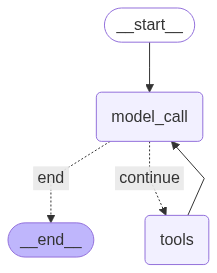

In [6]:
graph = StateGraph(AgentState)
graph.add_node("model_call", Model_call)


tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("model_call")

graph.add_conditional_edges(
    "model_call",
    Should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "model_call")

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

### Execution

In [7]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (call_roXJXH4ZrhgAR0MgQkfvMK09)
 Call ID: call_roXJXH4ZrhgAR0MgQkfvMK09
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  multiply (call_VImia7pQ4f8umqIAY3m9oHy2)
 Call ID: call_VImia7pQ4f8umqIAY3m9oHy2
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

The result of adding 40 and 12 is 52, and when you multiply that by 6, you get 312.

And here's a joke for you: Why don't scientists trust atoms? Because they make